## DBQAs as diagonalization algorithms

Let us start from some basic imports (and eventually installations).

In [1]:
# if needed, install Qibo uncommenting and executing the following
# !pip install qibo

In [2]:
import logging
        
from copy import deepcopy
from IPython.display import clear_output, display, Markdown

import numpy as np
import matplotlib.pyplot as plt

# Optimization tool: evolutionary algorithm
import cma

import qibo
from qibo import hamiltonians, set_backend
from qibo.symbols import Z

from qibo.models.dbi.double_bracket import (
    # the DBI main class
    DoubleBracketIteration,
    # class which build the generator of the rotations
    DoubleBracketGeneratorType,
)

In [3]:
# The following will help in reducing warnings outputs
class SpecificWarningFilter(logging.Filter):
    def filter(self, record):
        return (
            "Calculating the dense form of a symbolic Hamiltonian"
            not in record.getMessage()
        )

qibo_logger = qibo.config.log
qibo_logger.addFilter(SpecificWarningFilter())

In [4]:
# Set a Qibo backend
# Use Qibojit for better performance when using more than 20 qubits
set_backend("numpy")

[Qibo 0.2.14|INFO|2024-11-28 16:32:13]: Using numpy backend on /CPU:0


Let us add some plotting functions.

In [5]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    # print the abs value of the components of the matrix
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)

def plot_loss(losses, steps, labels=[""], title=""):
    """
    Plot loss functions returned by many DBI iterations with two subplots:
    - Left: Iteration vs Loss (original plot)
    - Right: Cumulative steps vs Loss
    """
    # Generate n colors
    colors = ["#ec6c6c", "#dc9d35", "#68da85", "#687fda", "#a768da"]

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # Left subplot: Original plot
    for i, loss in enumerate(losses):
        axs[0].plot(loss, color=colors[i % len(colors)], marker="o", label=labels[i])
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Off-diag norm")
    if len(labels) > 1:
        axs[0].legend()
    
    # Right subplot: Cumulative steps vs Loss
    for i, loss in enumerate(losses):
        # Compute cumulative steps
        cumulative_steps = np.cumsum(steps[i])
        axs[1].plot(cumulative_steps, loss, color=colors[i % len(colors)], marker="o", label=labels[i])
    axs[1].set_xlabel("Time (cumulative s)")
    if len(labels) > 1:
        axs[1].legend()
    
    # Overall title
    if title:
        fig.suptitle(title)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()


For the sake of this tutorial notebook, we will consider as input Hamiltonian a 1 dimensional Heisenberg XXZ. It is clearly a problem which can be addressed by using Tensor Network methods, or Bethe ansatze, but it will be used as illustrative example.
Actually, for some of the DBIs we discuss below, a more complex (non integrable) model could be less problematic.

In [6]:
# Some hyper-parameters
nqubits = 5
nsteps = 10

# Let's target the Heisenberg Hamiltonian
h0 = hamiltonians.XXZ(nqubits=nqubits, delta=0.5, dense=True)

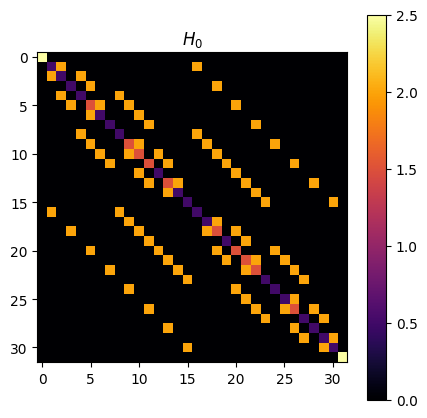

In [7]:
visualize_matrix(h0.matrix, r"$H_0$")

#### Recap of the DBI tools

We target an input hamiltonian $\hat{H}_0$, to which we apply a sequence of rotations:
$$ \hat{H}_{k+1} = e^{s_k \hat{W}_k(\vec{\theta})} \hat{H}_k e^{-s_k \hat{W}_k(\vec{\theta})},$$
where $s_k$ is the DBI step size and the rotation is generated by
$$ \hat{W}_k(\vec{\theta}) = [ \hat{D}_k(\vec{\theta}), \hat{H}_k]. $$

We will optimize the DBI by finding optimal parameters $s_k$ and $\vec{\theta}$ in the second part of the notebook.

---

To setup the double bracket quantum algorithm we have to decide which rotation generator to use. Let's list them and then start with the more natural one.

In [9]:
for generator in DoubleBracketGeneratorType:
    print(generator)

DoubleBracketGeneratorType.canonical
DoubleBracketGeneratorType.single_commutator
DoubleBracketGeneratorType.group_commutator
DoubleBracketGeneratorType.group_commutator_third_order


The canonical is the most natural choice:
$$ \hat{W}_k = [ \hat{\Delta}(\hat{H}_k), \hat{H}_k], $$
where in practice we use the diagonal part of the input Hamiltonian as diagonal operator to construct the rotation generator. 
In this notebook we will make use of the canonical operator at first, and then we will switch to the group commutator.

In [10]:
canonical = DoubleBracketGeneratorType.canonical

#### Execute one step of DBI

In [11]:
dbi = DoubleBracketIteration(
    hamiltonian=deepcopy(h0), 
    mode=canonical
)

print(f"Off diagonal norm before applying DBI: {dbi.off_diagonal_norm}")
dbi(step=0.05)
print(f"Off diagonal norm after applying DBI: {dbi.off_diagonal_norm}")

Off diagonal norm before applying DBI: 17.88854381999832
Off diagonal norm after applying DBI: 15.244312144486342


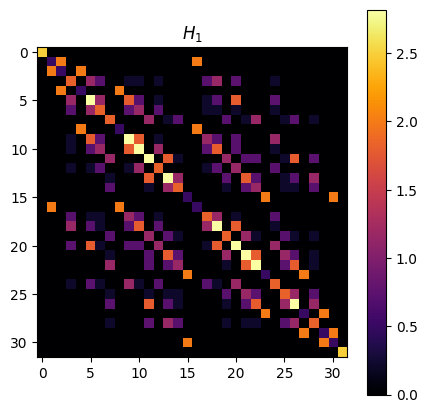

In [12]:
visualize_matrix(dbi.h.matrix, r"$H_1$")

#### Let's have a look to the class DBI

In [13]:
# Format as Markdown
attributes = [
    attr for attr in dir(dbi) if not callable(getattr(dbi, attr)) 
    and not attr.startswith("__")
]
methods = [
    method for method in dir(dbi) if callable(getattr(dbi, method)) 
    and not method.startswith("__")]

# Build the Markdown content
markdown_content = "### Attributes:\n- " + "\n- ".join(attributes) + "\n\n### Methods:\n- " + "\n- ".join(methods)

# Display the content
display(Markdown(markdown_content))

### Attributes:
- backend
- cost
- diagonal_h_matrix
- h
- h0
- mode
- nqubits
- off_diag_h
- off_diagonal_norm
- ref_state

### Methods:
- choose_step
- commutator
- cost_expansion
- energy_fluctuation
- eval_dbr_unitary
- generate_gamma_list
- least_squares
- loss
- scheduling
- sigma

#### Execute more steps of DBI

In [14]:
def n_db_iterations(dbi, nsteps=30, stepsize=0.01, optimize_step=False, d=None):
    """Repeat `nsteps` times the DBI execution."""
    offdiag_norms = [dbi.off_diagonal_norm]
    steps = [0.]
    for _ in range(nsteps):
        if optimize_step:
            stepsize = optimize_stepsize(dbi=dbi, grid_size=100, d=d)
        steps.append(stepsize)
        dbi(step=stepsize, d=d)
        offdiag_norms.append(dbi.off_diagonal_norm)
    return offdiag_norms, steps

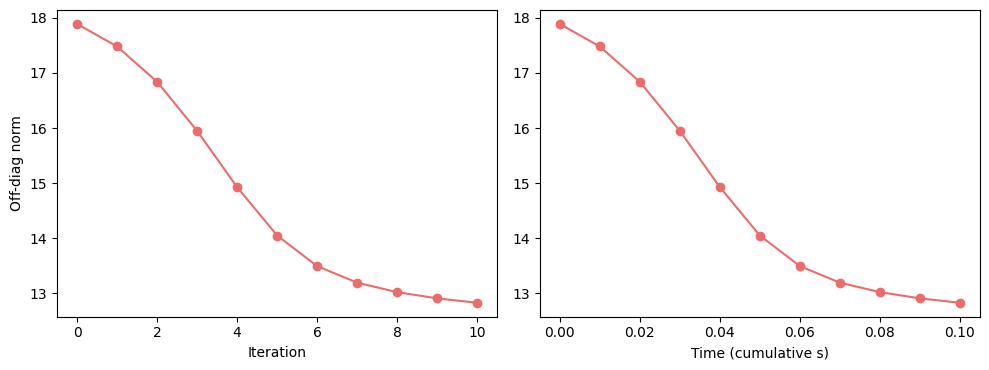

In [15]:
# initialize DBI
dbi = DoubleBracketIteration(
    hamiltonian=deepcopy(h0), 
    mode=canonical,
)

# execute ntimes
offdiag_norms, steps_can = n_db_iterations(dbi=dbi, nsteps=nsteps)

# plot the loss function
plot_loss(losses=[offdiag_norms], steps=[steps_can])

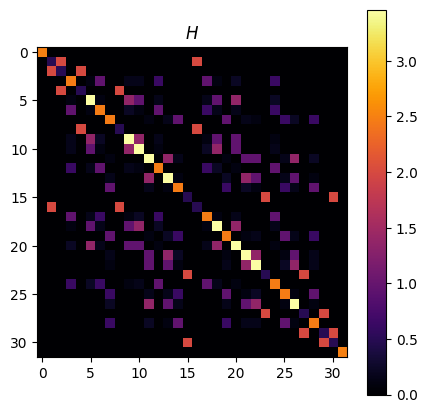

In [16]:
visualize_matrix(dbi.h.matrix, r"$H$")

In [17]:
exact_value = np.min(h0.eigenvalues())
dbi_approx = np.real(np.min(dbi.diagonal_h_matrix))

print(f"Exact ground state energy: {exact_value}")
print(f"GS Energy according to our diagonalization: {dbi_approx}")
print(f"Absolute difference of the values: {np.abs(exact_value - dbi_approx)}")

Exact ground state energy: -6.280513769031026
GS Energy according to our diagonalization: -3.4610524016659574
Absolute difference of the values: 2.819461367365069


#### Optimize the step duration

Let us start by implementing the simpler step optimization ever: a grid search.
This is not optimal, but helps in understanding the importance of hyper-optimizing the DBI. Later in the notebook, we will adopt a smarter strategy to optimize the DBI parameters.

In [18]:
def optimize_stepsize(dbi, d=None, step_range=[-5, 0], grid_size=30):
    """Optimize the stepsize on a grid of values."""
    step_grid = np.logspace(step_range[0], step_range[1], grid_size)

    losses = [dbi.off_diagonal_norm]
    for step in step_grid:
        dbi_copy = deepcopy(dbi)
        dbi_copy(step=step, d=d)
        losses.append(dbi_copy.off_diagonal_norm)

    return step_grid[np.argmin(losses) - 1]

In [19]:
# reset the dbi into the initial configuration
dbi_optimized = DoubleBracketIteration(
    hamiltonian=deepcopy(h0), 
    mode=canonical,
)

# execute ntimes
offdiag_opt, steps_can_opt = n_db_iterations(
    dbi=dbi_optimized, 
    nsteps=nsteps, 
    optimize_step=True,
)

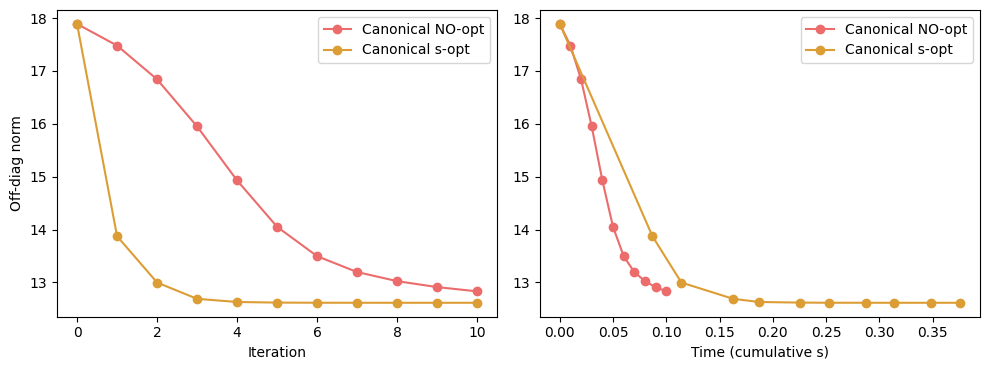

In [20]:
# plot the loss function
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt
    ], 
    steps=[
        steps_can,
        steps_can_opt,
    ],
    labels=[
        "Canonical NO-opt", 
        "Canonical s-opt"]
)

It seems we can converge faster, but with a similar limit plateau. Let's then change generator type. 

#### Let's use an adaptive rotation generator 

Knowing our Hamiltonian has symmetries, we adopt a variational strategy to check if we manage to have a better performance in diagonalizing it.

In [21]:
# let's choose the commutator generator
comm_gen = DoubleBracketGeneratorType.group_commutator

# a dummy diagonal operator
d_op = np.diag(np.linspace(1,2**nqubits,2**nqubits))
print(d_op)

dbi_comm = DoubleBracketIteration(
    hamiltonian=deepcopy(h0), 
    mode=comm_gen
)

[[ 1.  0.  0. ...  0.  0.  0.]
 [ 0.  2.  0. ...  0.  0.  0.]
 [ 0.  0.  3. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 30.  0.  0.]
 [ 0.  0.  0. ...  0. 31.  0.]
 [ 0.  0.  0. ...  0.  0. 32.]]


In [22]:
offdiag_comm, steps_comm = n_db_iterations(
    dbi=dbi_comm, 
    nsteps=nsteps, 
    optimize_step=True, 
    d=d_op
)

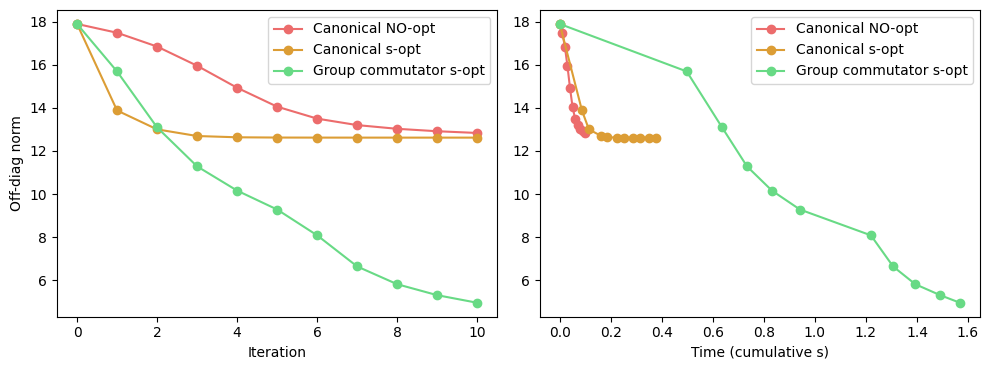

In [23]:
# plot the loss function
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt, 
        offdiag_comm
    ], 
    steps=[
        steps_can,
        steps_can_opt,
        steps_comm,
    ],
    labels=[
        "Canonical NO-opt", 
        "Canonical s-opt", 
        "Group commutator s-opt"
    ]
)

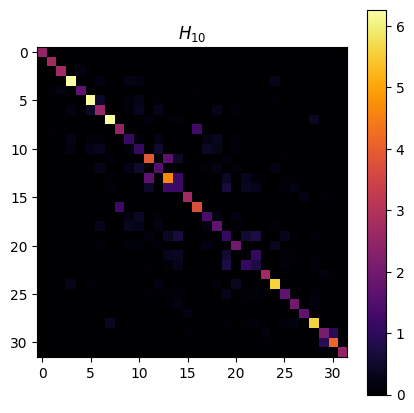

In [24]:
visualize_matrix(dbi_comm.h.matrix, r"$H_{10}$")

In [25]:
exact_value = np.min(h0.eigenvalues())
dbi_approx = np.real(np.min(dbi_comm.diagonal_h_matrix))

print(f"Exact ground state energy: {exact_value}")
print(f"GS Energy according to our diagonalization: {dbi_approx}")
print(f"Absolute difference of the values: {np.abs(exact_value - dbi_approx)}")

Exact ground state energy: -6.280513769031026
GS Energy according to our diagonalization: -6.260352707135264
Absolute difference of the values: 0.020161061895762167


#### Parametrize the D operator

We can now try to do something better using the same DBI setup but playing around with the parameters of the $\hat{D}$ operator.

In [26]:
def TFIM_d_operator(nqubits, params, print_symbolical=False):
    """
    Parametrize the D operator in form of a classical Transverse Field Ising Model.

    Args:
        nqubits (int): number of qubits;
        params (List[float]): list of coefficients for Z and Z * Z terms in TFIM. 
            It has to be 2 * nqubits long;
    """
    symbolical_d = 0

    for q in range(nqubits):
        symbolical_d += params[::2][q] * Z(q)
        symbolical_d += params[1::2][q] * Z(q) * Z((q + 1) % nqubits)

    if print_symbolical:
        print(symbolical_d)
    
    return hamiltonians.SymbolicHamiltonian(form=symbolical_d).matrix

In [27]:
# random initialization for TFIM
params = np.random.uniform(0., 3., 2 * nqubits)

# setup the D operator
d_op_tfim = TFIM_d_operator(nqubits, params, print_symbolical=True)

0.473525029620845*Z0 + 2.49180654489844*Z0*Z1 + 2.87220034098625*Z1 + 1.80635269001666*Z1*Z2 + 2.08651183458806*Z2 + 0.536622562449531*Z2*Z3 + 2.95014526414486*Z3 + 1.25125142630525*Z3*Z4 + 1.24172431851746*Z4 + 1.65378736905153*Z4*Z0


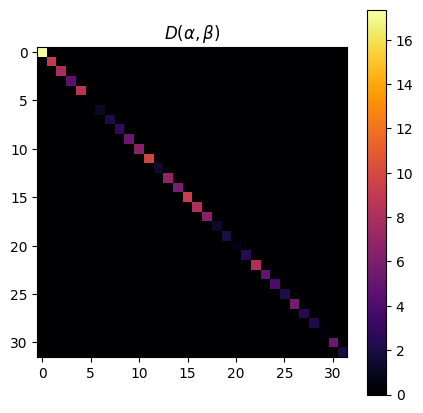

In [28]:
visualize_matrix(d_op_tfim, r"$D(\alpha, \beta)$")

In [29]:
dbi_comm_tfim = DoubleBracketIteration(
    hamiltonian=deepcopy(h0), 
    mode=comm_gen
)

In [30]:
offdiag_comm_tfim, steps_comm_tfim = n_db_iterations(
    dbi=dbi_comm_tfim, 
    nsteps=nsteps, 
    optimize_step=True, 
    d=d_op_tfim
)

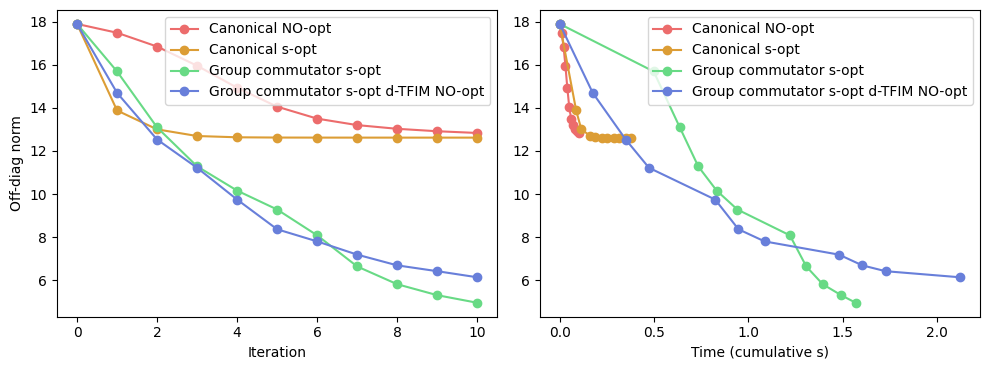

In [31]:
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt, 
        offdiag_comm, 
        offdiag_comm_tfim
    ], 
    steps=[
        steps_can,
        steps_can_opt,
        steps_comm,
        steps_comm_tfim,
    ],
    labels=[
        "Canonical NO-opt", 
        "Canonical s-opt", 
        "Group commutator s-opt",
        "Group commutator s-opt d-TFIM NO-opt",
    ]
)

#### Optimize the D operator

Now that $D$ has been parametrized, we can adopt a variational approach so that we minimize the number of steps required to reach a good diagonalization.

In [32]:
def loss_function_dbi(
    params, 
    dbi
):
    """
    Compute loss function given a DBI configuration, namely given stepsize and the alphas and betas
    which parametrize the D operator.

    Args:
        params (List[float]): variational parameters to be used in the DBI execution.
            The list has to be such that params[0] is the initial stepsize, and then 
            params[1:-1] are (alpha, beta, alpha, beta ...) coefficients of the TFIM parametrization.
        dbi (DoubleBracketIteration): double bracket iteration object.
    """
    dbi_copy = deepcopy(dbi)
    # collect parameters
    d_op = TFIM_d_operator(dbi_copy.h.nqubits, params=params[1:])
    dbi_copy(step=params[0], d=d_op)
    return dbi_copy.off_diagonal_norm

def optimize_DBI(
    dbi, 
    params, 
    s_bounds=(1e-4, 1.), 
    b_bounds=(-9., 9.),
):
    """
    Optimize all hyper-parameters of the DBI, namely the stepsize and the alphas and betas
    which parametrize the D operator.
    """

    lower_bounds = s_bounds[0] + b_bounds[0] * (len(params) - 1)
    upper_bounds = s_bounds[1] + b_bounds[1] * (len(params) - 1)
    bounds = [lower_bounds, upper_bounds]
    result = cma.fmin(
        loss_function_dbi,
        sigma0=0.5,
        x0=params,
        args=(dbi,),
        options={"bounds": bounds, "maxiter": 100},
    )[0]
    return result

In [33]:
# Initialize DBI 
dbi_comm_tfim_opt = DoubleBracketIteration(
    hamiltonian=deepcopy(h0), 
    mode=comm_gen
)

# Initial parameters
params = [0.01]
params.extend(np.random.uniform(0., 6., nqubits * 2))

# We collect offdiag norm and steps
offdiag_tfim_opt = [dbi_comm_tfim_opt.off_diagonal_norm]
steps_comm_tfim_opt = [0.]

# nsteps time optimization + DBI ex
for n in range(nsteps):
    print("#########################################")
    print(f"Optimized procedure step {n+1}/{nsteps}")
    print("#########################################\n")
    # Collect optimized DBI parameters, both stepsize and TFIM model's
    best_params = optimize_DBI(dbi=dbi_comm_tfim_opt, params=params)
    # Save the stepsize value
    steps_comm_tfim_opt.append(np.abs(best_params[0]))
    # Execute the DBI
    dbi_comm_tfim_opt(
        step=best_params[0], 
        d=TFIM_d_operator(nqubits, best_params[1:])
    )
    # Collect the off-diagonal norm value
    offdiag_tfim_opt.append(dbi_comm_tfim_opt.off_diagonal_norm)
    clear_output(wait=True)

#########################################
Optimized procedure step 10/10
#########################################

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 11 (seed=892144, Thu Nov 28 16:49:15 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 3.646322853140081e+00 1.0e+00 4.31e-01  4e-01  4e-01 0:00.5
    2     22 3.595730461974442e+00 1.1e+00 4.15e-01  4e-01  4e-01 0:01.0
    3     33 3.605968520566144e+00 1.2e+00 4.04e-01  4e-01  4e-01 0:01.4
   13    143 3.575713482547608e+00 1.9e+00 2.60e-01  2e-01  3e-01 0:04.5
   28    308 3.527609852916965e+00 3.2e+00 2.54e-01  1e-01  3e-01 0:08.6
   48    528 3.403031417942727e+00 5.3e+00 5.41e-01  2e-01  7e-01 0:13.6
   70    770 3.300806841782548e+00 7.8e+00 3.64e-01  9e-02  5e-01 0:19.9
   91   1001 3.268058196410029e+00 1.5e+01 2.32e-01  3e-02  3e-01 0:27.0
  100   1100 3.231030476874922e+00 2.1e+01 2.04e-01  2e-02  2e-01 0:29.4
termination on maxiter=100 (Thu Nov 28 16:49:45 2024)
final/bes

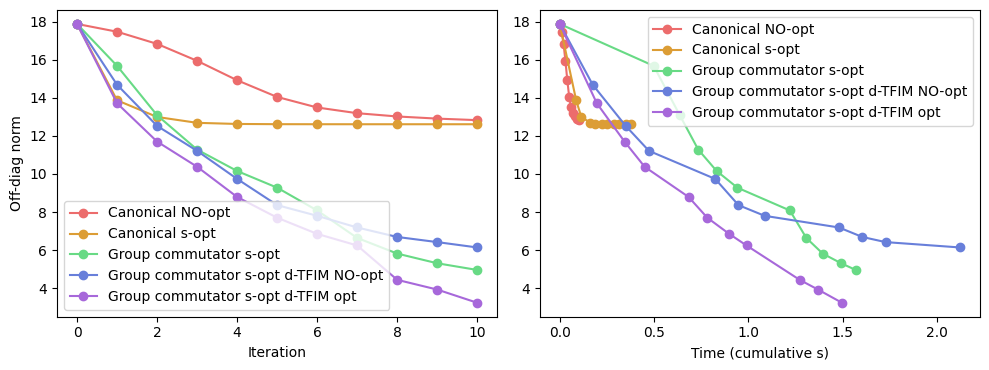

In [34]:
plot_loss(
    losses=[
        offdiag_norms, 
        offdiag_opt, 
        offdiag_comm, 
        offdiag_comm_tfim,
        offdiag_tfim_opt,
    ], 
    steps=[
        steps_can,
        steps_can_opt,
        steps_comm,
        steps_comm_tfim,
        steps_comm_tfim_opt,
    ],
    labels=[
        "Canonical NO-opt", 
        "Canonical s-opt", 
        "Group commutator s-opt",
        "Group commutator s-opt d-TFIM NO-opt",
        "Group commutator s-opt d-TFIM opt",
    ]
)

In [35]:
exact_value = np.min(h0.eigenvalues())
dbi_approx = np.real(np.min(dbi_comm_tfim_opt.diagonal_h_matrix))

print(f"Exact ground state energy: {exact_value}")
print(f"GS Energy according to our diagonalization: {dbi_approx}")
print(f"Absolute difference of the values: {np.abs(exact_value - dbi_approx)}")

Exact ground state energy: -6.280513769031026
GS Energy according to our diagonalization: -6.273616782928448
Absolute difference of the values: 0.006896986102578495


In [ ]:
_